![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/01.Page_Splitting.ipynb)

# Installation

In [ ]:
! pip install -q johnsnowlabs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.6/570.6 KB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.5/469.5 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.8 MB/s eta 0:00:00


## Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, finance

# nlp.install(force_browser=True)

## Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

Please Upload your John Snow Labs License using the button below


Saving 4.3.0.spark_nlp_for_healthcare-2.json to 4.3.0.spark_nlp_for_healthcare-2.json


- Install it

In [ ]:
nlp.install()

👌 Detected license file /content/4.3.0.spark_nlp_for_healthcare-2.json
📋 Stored John Snow Labs License in /root/.johnsnowlabs/licenses/license_number_0_for_Spark-Healthcare_Spark-OCR.json
👷 Setting up  John Snow Labs home in /root/.johnsnowlabs, this might take a few minutes.
🙆 JSL Home setup in /root/.johnsnowlabs
👌 Detected license file /content/4.3.0.spark_nlp_for_healthcare-2.json
Installing /root/.johnsnowlabs/py_installs/spark_nlp_jsl-4.3.0-py3-none-any.whl to /usr/bin/python3
Installed 1 products:
💊 Spark-Healthcare==4.3.0 installed! ✅ Heal the planet with NLP! 


# Starting

In [ ]:
spark = nlp.start()

👌 Detected license file /content/4.3.0.spark_nlp_for_healthcare-2.json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.3.0, 💊Spark-Healthcare==4.3.0, running on ⚡ PySpark==3.1.2


# Financial Text Splitting

Text splitting is very important for many reasons.

- Financial documents may be **very long** (e.g., filings, annual/quarterly reports) and applying AI to the whole document may take much time.
- Most Language Models have **token restrictions**. For example, Bert-based models can only process up to 512 tokens, while our biggest LM (Longformers) can process up to 4096 (but affecting negatively to the performance).
- If you have models which do specific extractions on **specific sections**, it does not make sense you run them over the whole document: you may get a lot of False Positives.

But also:
- Language Models will only "understand" only that **portion of text you send to them**. If you send *little information*, they may be biased and take wrong decisions.
- On the other hand, sometimes sending *too much information* makes the information get deluded or add noise.

And!
- Make sure the tokenization and splitting mechanism is the same in training and inference, or you will get undesirable results.

Because of these reasons, the very first thing you need to think about is how to properly split your texts, depending on the kind of task you want to carry out.




# 1. Text Classification

# 1.1. Background
Text classification is the NLP task in charge of retrieving a `category` based on a piece of text you send to the model. A good example of it it's Section or Item identification in Financial Documents.

There are several ways we can carry out Text Classification:

- `At a whole-text level (no splitting)`: That's not feasible for most financial documents. As we already know, we have a token restrictions (512 for most BERT-based thansformers). We can use Longformers (4096), but in most cases, documents as Financial Reports have much more than that, what will go for sure beyond any limitation.

- `Retrieving first page`: In most cases, the relevant information of a document is in the first page. Just by splitting by pages and retrieving the first one, you can do text classification. 

- `At paragraph, section or sentence level using Finance NLP SentenceDetector`: `SentenceDetector` is an NLP annotator that it's meant to split documents into sentences, but is pretty customisable to retrieve paragraphs or setions as well. It works with `regex` or list of character splitting, among other more complex techniques.

- `At paragraph, section or sentence level using NER` for detecting headers and `ChunkSentenceSplitter`

The way you split may totally change the results you are getting. Let's see an example.

# 1.2. Page splitting

Sometimes, pages have patterns which tell you how to split them. In our case, `Table of Contents` was present in the bottom of our documents.

Feel free to always analyze for signals when trying to detect pages boundaries. Patterns you can usually find in the bottom of a page:
- Number of page
- Bottom placeholders
- Name of people
- Name of the document
- etc.

In [ ]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentence_detector = nlp.SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("pages")\
    .setCustomBounds(["Table of Contents"])\
    .setUseCustomBoundsOnly(True)\
    .setExplodeSentences(True)

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    sentence_detector])

Explanation:
- `.setCustomBounds(["Table of Contents"])` sets an array of regular expression(s) to tell the annotator how to split the document.
- `.setUseCustomBoundsOnly(True)` the default behaviour of SentenceDetector is Sentence Splitting, so we set to ignore the default regex ('\n', ...).
- `.setExplodeSentences(True)` creates one new row in the dataframe per split.


Let's download a document and use `whole-text` classifiers.

In [ ]:
import requests
URL = "https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/finance-nlp/data/cdns-20220101.html.txt"
response = requests.get(URL)

cadence_sec10k = response.content.decode('utf-8')

Let's apply our page splitter.

## Using Fit/Transform (all the dataframe will be processed in paralel using all the spark cluster nodes)

In [ ]:
#fit: trains, configures and prepares the pipeline for inference. 

sdf = spark.createDataFrame([[ cadence_sec10k ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)

In [ ]:
%%time

#transforms: executes inference on a fit pipeline
res = fit.transform(sdf)

res.show()

+--------------------+--------------------+--------------------+
|                text|            document|               pages|
+--------------------+--------------------+--------------------+
|Table of Contents...|[{document, 0, 34...|[{document, 18, 4...|
|Table of Contents...|[{document, 0, 34...|[{document, 4087,...|
|Table of Contents...|[{document, 0, 34...|[{document, 4215,...|
|Table of Contents...|[{document, 0, 34...|[{document, 5504,...|
|Table of Contents...|[{document, 0, 34...|[{document, 11617...|
|Table of Contents...|[{document, 0, 34...|[{document, 13985...|
|Table of Contents...|[{document, 0, 34...|[{document, 20001...|
|Table of Contents...|[{document, 0, 34...|[{document, 26059...|
|Table of Contents...|[{document, 0, 34...|[{document, 31638...|
|Table of Contents...|[{document, 0, 34...|[{document, 36733...|
|Table of Contents...|[{document, 0, 34...|[{document, 42440...|
|Table of Contents...|[{document, 0, 34...|[{document, 47053...|
|Table of Contents...|[{d

## Using LightPipelines (everything will be executed in 1 node. It's much quicker for small dataframes, but does not leverage the cluster capacities)

In [ ]:
%%time
import json
lp = nlp.LightPipeline(fit)

json_res = lp.annotate(cadence_sec10k)

print(json.dumps(json_res, indent=4))

{
    "document": [
        "Table of Contents\nUNITED STATES SECURITIES AND EXCHANGE COMMISSION\nWashington, D.C. 20549\n_____________________________________ \nFORM 10-K \n_____________________________________  \n(Mark One)\n\u2612\nANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the fiscal year ended January 1, 2022 \nOR\n\u2610\nTRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the transition period from _________ to_________.\n\nCommission file number 000-15867 \n_____________________________________\n \nCADENCE DESIGN SYSTEMS, INC. \n(Exact name of registrant as specified in its charter)\n____________________________________ \nDelaware\n \n00-0000000\n(State or Other Jurisdiction ofIncorporation or Organization)\n \n(I.R.S. EmployerIdentification No.)\n2655 Seely Avenue, Building 5,\nSan Jose,\nCalifornia\n \n95134\n(Address of Principal Executive Offices)\n \n(Zip Code)\n(408)\n-943-1234 \n(Reg

In [ ]:
pages = [json_res['pages'][i] for i in range(0,20)]

# 1.3. Document Classification using the 1st page
Most of the documents can be identified by the 1 page (given it's a real 1st page and not a separation, cover page, page with noise, etc - you can filter those out).

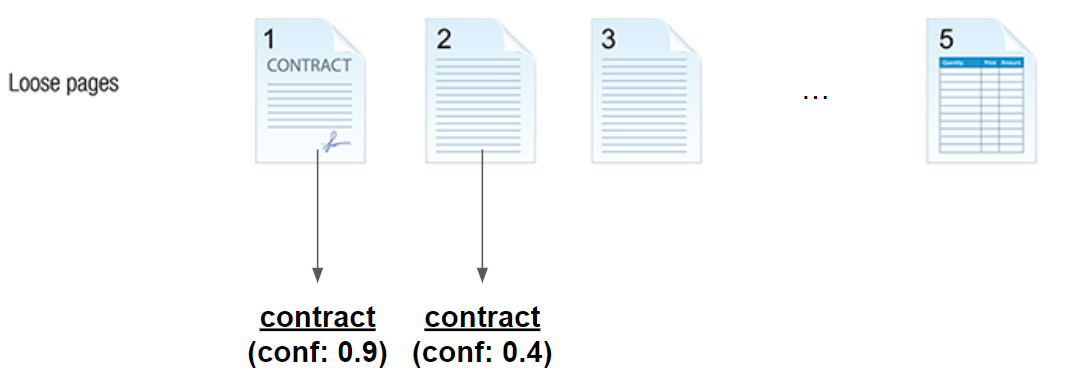

We have some text classifiers which can be used to identify different financial reports:
- `finclf_sec_filings_en`: This model allows you to classify documents among a list of specific US Security Exchange Commission filings, as `10-K, 10-Q, 8-K, S-8, 3, 4, Other`. IMPORTANT : This model works with the first 512 tokens of a document, you don't need to run it in the whole document.`
- `finclf_earning_broker_10k_en`: This is a Text Cassification model, which can help you identify if a model is an Earning Call, a Broker Report, a 10K filing or something else. IMPORTANT : This model works with the first 512 tokens of a document, you don't need to run it in the whole document.`
- ...
- missing something? Let us know and we will train that for you!

In [ ]:
documentAssembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

embeddings = nlp.BertSentenceEmbeddings.pretrained("sent_bert_base_cased", "en") \
    .setInputCols("document") \
    .setOutputCol("sentence_embeddings")

docClassifier = finance.ClassifierDLModel.pretrained("finclf_earning_broker_10k", "en", "finance/models")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("label") \

nlp_pipeline = nlp.Pipeline(stages=[
    documentAssembler,
    embeddings,
    docClassifier])

sent_bert_base_cased download started this may take some time.
Approximate size to download 389.1 MB
[OK!]
finclf_earning_broker_10k download started this may take some time.
[OK!]


### Using fit / transform (all Spark Cluster nodes)

In [ ]:
# Since the model works with the first 512 tokens, let's just send some initial characters...
sdf = spark.createDataFrame([[ pages[0] ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)
res = fit.transform(sdf)

res = res.select('label.result').show()

+------+
|result|
+------+
| [10k]|
+------+



### Using Light Pipeline (only driver, quicker but not scalable for big amounts of documents)

In [ ]:
from johnsnowlabs import nlp
import json

lp = nlp.LightPipeline(fit)
json_res = lp.annotate( pages[0] )
print(json.dumps(json_res, indent=4))

{
    "document": [
        "UNITED STATES SECURITIES AND EXCHANGE COMMISSION\nWashington, D.C. 20549\n_____________________________________ \nFORM 10-K \n_____________________________________  \n(Mark One)\n\u2612\nANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the fiscal year ended January 1, 2022 \nOR\n\u2610\nTRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the transition period from _________ to_________.\n\nCommission file number 000-15867 \n_____________________________________\n \nCADENCE DESIGN SYSTEMS, INC. \n(Exact name of registrant as specified in its charter)\n____________________________________ \nDelaware\n \n00-0000000\n(State or Other Jurisdiction ofIncorporation or Organization)\n \n(I.R.S. EmployerIdentification No.)\n2655 Seely Avenue, Building 5,\nSan Jose,\nCalifornia\n \n95134\n(Address of Principal Executive Offices)\n \n(Zip Code)\n(408)\n-943-1234 \n(Registrant\u2019s Tele

### Are you curious of what would happen with other pages?

In [ ]:
json_res = lp.annotate( [ pages[0], pages[1], pages[5], pages[10], pages[15], pages[19]] )
print(json.dumps(json_res, indent=4))

[
    {
        "document": [
            "UNITED STATES SECURITIES AND EXCHANGE COMMISSION\nWashington, D.C. 20549\n_____________________________________ \nFORM 10-K \n_____________________________________  \n(Mark One)\n\u2612\nANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the fiscal year ended January 1, 2022 \nOR\n\u2610\nTRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the transition period from _________ to_________.\n\nCommission file number 000-15867 \n_____________________________________\n \nCADENCE DESIGN SYSTEMS, INC. \n(Exact name of registrant as specified in its charter)\n____________________________________ \nDelaware\n \n00-0000000\n(State or Other Jurisdiction ofIncorporation or Organization)\n \n(I.R.S. EmployerIdentification No.)\n2655 Seely Avenue, Building 5,\nSan Jose,\nCalifornia\n \n95134\n(Address of Principal Executive Offices)\n \n(Zip Code)\n(408)\n-943-1234 \n(Registra

Ok our classifiers, which work on the top 512 tokens, say we have a **10K document** by using the first page.

# 1.4. Paragraph / Section / Items splitting

## SentenceDetector
To split by sentences or paragraphs or ...

In most cases:
- paragraphs can be extracted using just `\n\n`.
- sections and items may be delimited by headers and subheaders. We can train DL models to detect them or, if use numeration (if they are numerated sections) or other patterns to delimit their boundaries


In [ ]:
example1 = """PART I

ITEM 1. BUSINESS.
Company Overview
Inuvo is a technology company that develops and sells information technology solutions for marketing.

ITEM 1A. RISK FACTORS.
An investment in our common stock involves a significant degree of risk.

ITEM 1B. UNRESOLVED STAFF COMMENTS.
Not applicable to a smaller reporting company.

ITEM 2. PROPERTIES.
Our corporate headquarters are located in Little Rock, Arkansas where we entered into a five-year agreement to lease office space on October 1, 2015 and amended the lease as of February 1, 2021
Angeles, CA, San Jose, CA and Secaucus, NJ.

ITEM 3. LEGAL PROCEEDINGS.
We are not party to any pending legal proceedings.

ITEM 4. MINE SAFETY DISCLOSURES.
Not applicable.

PART II
ITEM 5. MARKET FOR REGISTRANT’S COMMON EQUITY, RELATED STOCKHOLDER MATTERS AND ISSUER PURCHASES OF EQUITY SECURITIES.
Market Information"""

By `\n\n`...

In [ ]:
sentence_detector = nlp.SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("paragraphs")\
    .setCustomBounds(["\n\n"])\
    .setUseCustomBoundsOnly(True)\
    .setExplodeSentences(True)

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    sentence_detector])

sdf = spark.createDataFrame([[ example1 ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)
res = fit.transform(sdf)

res = res.select('paragraphs.result').show(truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                                                                                             |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[PART I]                                                                                                                                                                                                             

In [ ]:
sentence_detector = nlp.SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("paragraphs")\
    .setCustomBounds(["\n\n"])\
    .setUseCustomBoundsOnly(True)\
    .setExplodeSentences(True)

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    sentence_detector])

sdf = spark.createDataFrame([[ example1 ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)
res = fit.transform(sdf)

res = res.select('paragraphs.result').show(truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                                                                                             |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[PART I]                                                                                                                                                                                                             

By other regular expressions ...

In [ ]:
example2 = """PART I
ITEM 1. BUSINESS.
Company Overview
Inuvo is a technology company that develops and sells information technology solutions for marketing.
ITEM 1A. RISK FACTORS.
An investment in our common stock involves a significant degree of risk.
ITEM 1B. UNRESOLVED STAFF COMMENTS.
Not applicable to a smaller reporting company.
ITEM 2. PROPERTIES.
Our corporate headquarters are located in Little Rock, Arkansas where we entered into a five-year agreement to lease office space on October 1, 2015 and amended the lease as of February 1, 2021
Angeles, CA, San Jose, CA and Secaucus, NJ.
ITEM 3. LEGAL PROCEEDINGS.
We are not party to any pending legal proceedings.
ITEM 4. MINE SAFETY DISCLOSURES.
Not applicable.
PART II
ITEM 5. MARKET FOR REGISTRANT’S COMMON EQUITY, RELATED STOCKHOLDER MATTERS AND ISSUER PURCHASES OF EQUITY SECURITIES.
Market Information"""

In [ ]:
sentence_detector = nlp.SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("paragraphs")\
    .setCustomBounds(["[A-Z]{4,}[ ]*[0-9]*[A-Z]*\.? ?"])\
    .setUseCustomBoundsOnly(True)\
    .setExplodeSentences(True)

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    sentence_detector])

sdf = spark.createDataFrame([[ example2 ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)
res = fit.transform(sdf)

res = res.select('paragraphs.result').show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[Company Overview
Inuvo is a technology company that develops and sells information technology solutions for marketing.]                                                                                                                       |
|[An investment in our common st

BE CAREFUL. If you use a pattern to split and you want it to be included, use `setCustomBoundsStrategy` to `prepend` (goes as the first part of the next section) or `append` (goes as a last part of the previous section)

In [ ]:
sentence_detector = nlp.SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("paragraphs")\
    .setCustomBounds(["[A-Z]{4,}[ ]*[0-9]*[A-Z]*\.? ?"])\
    .setUseCustomBoundsOnly(True)\
    .setExplodeSentences(True)\
    .setCustomBoundsStrategy('prepend')

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    sentence_detector])

sdf = spark.createDataFrame([[ example2 ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)
res = fit.transform(sdf)


res = res.select('paragraphs.result').show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                                                                                     |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[PART I]                                                                                                                                                                                                                                     

## Using NER and ChunkSentenceSplitter


... using pretrained NER models for `Headers and Subheaders`

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

sentenceDetector = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl","xx")\
        .setInputCols(["document"])\
        .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
        .setInputCols(["sentence"])\
        .setOutputCol("token")

embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base","en") \
        .setInputCols(["sentence", "token"]) \
        .setOutputCol("embeddings")

ner_model = finance.NerModel.pretrained("finner_headers", "en", "finance/models")\
        .setInputCols(["sentence", "token", "embeddings"])\
        .setOutputCol("ner")

ner_converter = finance.NerConverterInternal()\
        .setInputCols(["sentence","token","ner"])\
        .setOutputCol("ner_chunk")

nlp_pipeline = nlp.Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        embeddings,
        ner_model,
        ner_converter])

sentence_detector_dl download started this may take some time.
Approximate size to download 514.9 KB
[OK!]
bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]
finner_headers download started this may take some time.
[OK!]


In [ ]:
sdf = spark.createDataFrame([[ example2 ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)

lp = nlp.LightPipeline(fit)

In [ ]:
res = lp.fullAnnotate(example2)

In [ ]:
from johnsnowlabs import viz

ner_viz = viz.NerVisualizer()

ner_viz.display(res[0], label_col='ner_chunk')

In [ ]:
ner_res = res[0]['ner_chunk'] # Document 0

sections = []
for ann in ner_res:
  sections.append( (ann.begin, ann.end) )
sections

[(0, 5),
 (7, 22),
 (25, 40),
 (144, 150),
 (153, 164),
 (240, 273),
 (323, 329),
 (331, 340),
 (581, 587),
 (589, 605),
 (659, 689),
 (708, 714),
 (716, 831),
 (834, 851)]

In [ ]:
section_texts = []
last_section = 0
last_section_name = ""
for s in sections:
  t = last_section_name + example2[last_section:s[0]]
  if t != '':
    section_texts.append(t)
  last_section = s[1]+1
  last_section_name = example2[s[0]:s[1]+1]
section_texts.append(last_section_name + example2[last_section:s[0]])


In [ ]:
OKGREEN = '\033[92m'
ENDC = '\033[0m'

In [ ]:
for t in section_texts:
  print(f"{OKGREEN}SECTION:{ENDC}\n{t}")

SECTION:
PART I

SECTION:
ITEM 1. BUSINESS.

SECTION:
Company Overview
Inuvo is a technology company that develops and sells information technology solutions for marketing.

SECTION:
ITEM 1A. 
SECTION:
RISK FACTORS.
An investment in our common stock involves a significant degree of risk.

SECTION:
ITEM 1B. UNRESOLVED STAFF COMMENTS.
Not applicable to a smaller reporting company.

SECTION:
ITEM 2. 
SECTION:
PROPERTIES.
Our corporate headquarters are located in Little Rock, Arkansas where we entered into a five-year agreement to lease office space on October 1, 2015 and amended the lease as of February 1, 2021
Angeles, CA, San Jose, CA and Secaucus, NJ.

SECTION:
ITEM 3. 
SECTION:
LEGAL PROCEEDINGS.
We are not party to any pending legal proceedings.

SECTION:
ITEM 4. MINE SAFETY DISCLOSURES.
Not applicable.

SECTION:
PART II

SECTION:
ITEM 5. MARKET FOR REGISTRANT’S COMMON EQUITY, RELATED STOCKHOLDER MATTERS AND ISSUER PURCHASES OF EQUITY SECURITIES.

SECTION:
Market Information


... or automatically using ChunkSentenceSpliting...

In [ ]:
chunkSentenceSplitter = finance.ChunkSentenceSplitter()\
    .setInputCols("document","ner_chunk")\
    .setOutputCol("paragraphs")\
    .setGroupBySentences(False)

    
nlp_pipeline = nlp.Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        embeddings,
        ner_model,
        ner_converter,
        chunkSentenceSplitter])


paragraphs = nlp_pipeline.fit(sdf).transform(sdf)

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
result_df = paragraphs.selectExpr("explode(paragraphs) as result").selectExpr("result.result","result.metadata.entity").toPandas()
result_df.head()

,result,entity
0,PART I\n,HEADER
1,ITEM 1. BUSINESS.\n,HEADER
2,Company Overview\nInuvo is a technology company that develops and sells information technology solutions for marketing.\n,SUBHEADER
3,ITEM 1A.,SUBHEADER
4,RISK FACTORS.\nAn investment in our common stock involves a significant degree of risk.\n,SUBHEADER


## Pretrained Pipeline for Section Splitting
This is just section splitting using NER with ContextualParser. 

So just use it to get some headers and subheaders from financial document like `1. Items` or `2.2. Disclousers ` etc.

You can check [this notebook](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/05.6.Contextual_Parser_Rule_Based_NER.ipynb) to learn how ContextualParser works.


In [ ]:
finance_pipeline = nlp.PretrainedPipeline("finpipe_header_subheader", "en", "finance/models")

In [ ]:
finance_pipeline.model.stages

[DocumentAssembler_b472a95d49de,
 REGEX_TOKENIZER_22dc8c206996,
 CONTEXTUAL-PARSER_d7bc800f45ce,
 CONTEXTUAL-PARSER_3c3c655d79ad,
 MERGE_981702c8024d]

This pre-trained Pipeline includes two ContextualParser. The first one extracts the `HEADER` section and the second one extracts the `SUBHEADER` section.

In [ ]:
text = ["""2. DEFINITION. 

For purposes of this Agreement, the following terms have the meanings ascribed thereto in this Section 1 and 2 Appointment as Reseller.

2.1 Appointment. 

The Company hereby [***]. Allscripts may also disclose Company's pricing information relating to its Merchant Processing Services and facilitate procurement of Merchant Processing Services on behalf of Sublicensed Customers, including, without limitation by references to such pricing information and Merchant Processing Services in Customer Agreements. 6

2.2 Customer Agreements."""]

result = finance_pipeline.fullAnnotate(text)[0]

result

{'document': [Annotation(document, 0, 553, 2. DEFINITION. 
  
  For purposes of this Agreement, the following terms have the meanings ascribed thereto in this Section 1 and 2 Appointment as Reseller.
  
  2.1 Appointment. 
  
  The Company hereby [***]. Allscripts may also disclose Company's pricing information relating to its Merchant Processing Services and facilitate procurement of Merchant Processing Services on behalf of Sublicensed Customers, including, without limitation by references to such pricing information and Merchant Processing Services in Customer Agreements. 6
  
  2.2 Customer Agreements., {}, [])],
 'merged_chunk': [Annotation(chunk, 0, 12, 2. DEFINITION, {'tokenIndex': '0', 'entity': 'HEADER', 'field': 'HEADER', 'chunk': '0', 'normalized': '', 'sentence': '0', 'confidenceValue': '0.50'}, []),
  Annotation(chunk, 154, 168, 2.1 Appointment, {'tokenIndex': '28', 'entity': 'SUBHEADER', 'field': 'SUBHEADER', 'chunk': '1', 'normalized': '', 'sentence': '0', 'confidenceVal

In [ ]:
chunks = []
entities = []
begin = []
end = []

for n in result['merged_chunk']:
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    
df = pd.DataFrame({'chunks':chunks, 
                   'begin': begin, 
                   'end':end, 
                   'entities':entities})
df.head(20)

,chunks,begin,end,entities
0,2. DEFINITION,0,12,HEADER
1,2.1 Appointment,154,168,SUBHEADER
2,2.2 Customer Agreements,530,552,SUBHEADER


In [ ]:
# Visualize outputs

visualiser = nlp.viz.NerVisualizer()

visualiser.display(result, label_col='merged_chunk', document_col='document', save_path="display_result_2.html")

## Contextual Parser for SUBHEADER

# 1.5. Paragraph Classification and the consequences of splitting

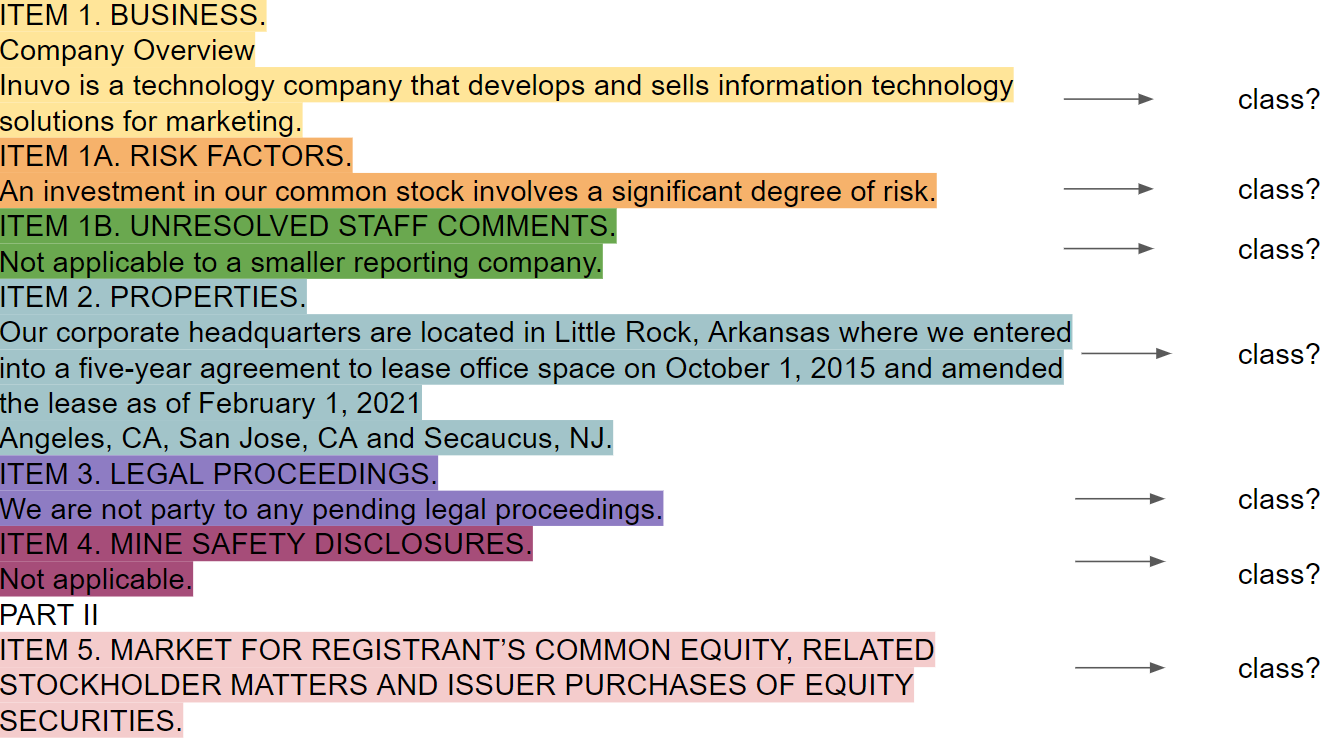


In Finance NLP we have several Text Classifiers to detect some useful sections of a 10K (or 10Q) filing. For example:
```
- finclf_acquisitions_item
- finclf_business_item
- finclf_equity_item
- finclf_exhibits_item
- finclf_executives_item
- finclf_properties_item
- finclf_work_experience_item
- finclf_controls_procedures_item
- finclf_security_ownership_item
- finclf_executives_compensation_item
- finclf_financial_statements_item
- finclf_market_risk_item
- finclf_financial_conditions_item
- finclf_legal_proceedings_item
- finclf_risk_factors_item
```
All of these models are Binary Classifiers, which means they will return True or False, or better to say ,the name of the class (for example, `acquisitions`) if the class `acquisition` is found, or `other` if it's not an `acquisition`, but something else.

CLARIFICATION: We did not want to return `True` or `False` because these models can all be stuck one after another, so in case a clause triggers some classes at the same time (they may not be disjoint) we could be getting several `True`, which is less informative than retrieving directly the type of the classes detected `acquisitions` and `properties` for example.


## Example of how splitting affects paragraph classification

In [ ]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentence_detector = nlp.SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("pages")\
    .setCustomBounds(["Table of Contents"])\
    .setUseCustomBoundsOnly(True)\
    .setExplodeSentences(True)

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    sentence_detector])

fit = nlp_pipeline.fit(spark.createDataFrame([[ cadence_sec10k ]]).toDF("text"))

In [ ]:
lp = nlp.LightPipeline(fit)

In [ ]:
res = lp.annotate(cadence_sec10k)
pages = res['pages']
pages = [p for p in pages if p.strip() != ''] # We remove empty pages

In [ ]:
candidates = [[pages[4]], [pages[84]], [pages[85]], [pages[86]], [pages[87]]]

In [ ]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

use_embeddings = nlp.UniversalSentenceEncoder.pretrained() \
    .setInputCols("document") \
    .setOutputCol("sentence_embeddings")

doc_classifier = finance.ClassifierDLModel.pretrained('finclf_work_experience_item', "en", "finance/models")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("category")

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler, 
    use_embeddings,
    doc_classifier])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
finclf_work_experience_item download started this may take some time.
[OK!]


In [ ]:
df = spark.createDataFrame(candidates).toDF("text")

model = nlp_pipeline.fit(df)

result = model.transform(df)
result.select('category.result').show()

+-----------------+
|           result|
+-----------------+
|          [other]|
|          [other]|
|          [other]|
|[work_experience]|
|          [other]|
+-----------------+



Page 86 has some information about people and their roles...

In [ ]:
print(pages[86][-800:])

ed Public Accounting Firm.
X
31.01
Certification of the Registrant’s Chief Executive Officer, Anirudh Devgan, pursuant to Rule 13a-14 of the Securities Exchange Act of 1934.
X
31.02
Certification of the Registrant’s Chief Financial Officer, John M. Wall, pursuant to Rule 13a-14 of the Securities Exchange Act of 1934.
X
32.01†
Certification of the Registrant’s Chief Executive Officer, Anirudh Devgan, pursuant to 18 U.S.C. Section 1350, as adopted pursuant to Section 906 of the Sarbanes-Oxley Act of 2002.
X
32.02†
Certification of the Registrant’s Chief Financial Officer, John M. Wall, pursuant to 18 U.S.C. Section 1350, as adopted pursuant to Section 906 of the Sarbanes-Oxley Act of 2002.
X
101.INS
Inline XBRL Instance Document.
X
101.SCH
Inline XBRL Taxonomy Extension Schema Document.
X
84


But page 4 too!

In [ ]:
print(pages[4][-800:])

of our customers.
Recent Acquisitions
During fiscal 2021, we continued to execute our Intelligent System Design strategy and expanded our product offerings and solutions into computational fluid dynamics (“CFD”) with our acquisitions of Belgium-based NUMECA International, a leader in CFD technology, and Pointwise, Inc, a leading provider of CFD meshing technology. The addition of these technologies and talent broadens our System Design and Analysis portfolio and expertise. 
Chief Executive Officer Transition
On December 15, 2021, Anirudh Devgan assumed the role of President and Chief Executive Officer of Cadence, replacing Lip-Bu Tan. Prior to his role as Chief Executive Officer, Dr. Devgan served as President of Cadence. Concurrently, Mr. Tan transitioned to the role of Executive Chair.
2


What happened?

In [ ]:
pages[4]

'The IC and SoC design excellence requires technologies for custom IC, digital IC design and signoff, and functional verification, and leverages pre-built semiconductor IP. These tools, IP and associated services are specifically designed to meet the growing requirements of engineers designing increasingly complex chips across analog, digital and mixed-signal domains, and perform the associated verification tasks, including validation of low-level software running on the silicon model, thereby enabling design teams to manage complexity and verification throughput without commensurately increasing the team size or extending the project schedule, while reducing technical risks.\nThe second layer of our strategy centers around system innovation. It includes tools and services used for system design of the packages that encapsulate the ICs and the PCBs, system simulation which includes electromagnetic, electro-thermal and other multi-physics analysis necessary as part of optimizing the ful

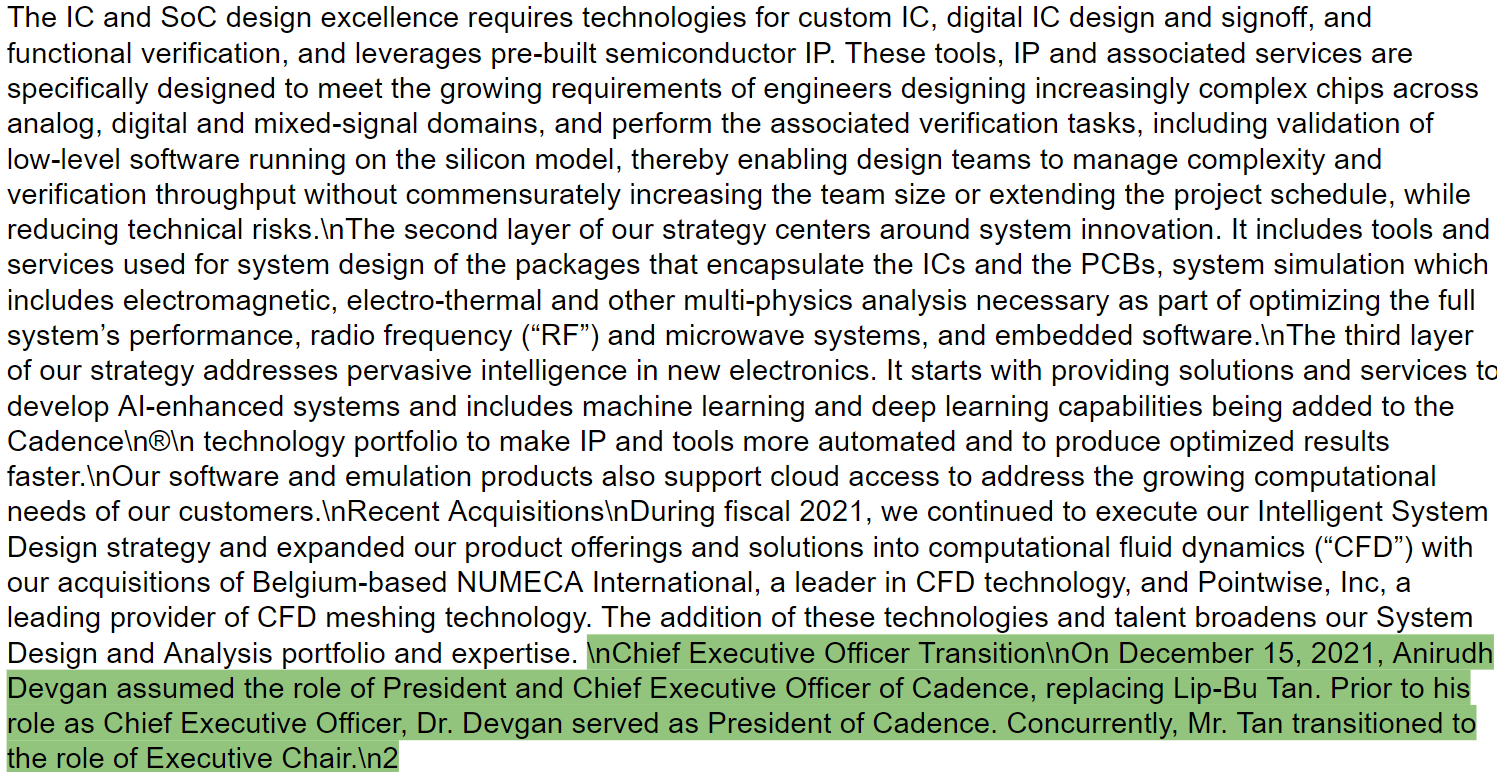

Predicting at page level added too much information, and the part of the CEO got deluded by the rest of the information!

Also token size restrictions may have happened!

SOLUTION: A smaller lever of granularity


In [ ]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentence_detector = nlp.SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("paragraphs")

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler, 
    sentence_detector])

In [ ]:
empty_data = spark.createDataFrame([[""]]).toDF("text")
sentence_splitting_pipe = nlp_pipeline.fit(empty_data)
sentence_splitting_lightpipe = nlp.LightPipeline(sentence_splitting_pipe)

In [ ]:
res = sentence_splitting_lightpipe.annotate(pages[4])
paragraphs = res['paragraphs']
paragraphs = [p for p in paragraphs if p.strip() != ''] # We remove empty pages

In [ ]:
candidates = [[x] for x in paragraphs]

In [ ]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

use_embeddings = nlp.UniversalSentenceEncoder.pretrained() \
    .setInputCols("document") \
    .setOutputCol("sentence_embeddings")

doc_classifier = finance.ClassifierDLModel.pretrained('finclf_work_experience_item', "en", "finance/models")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("category")

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler, 
    use_embeddings,
    doc_classifier])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
finclf_work_experience_item download started this may take some time.
[OK!]


In [ ]:
df = spark.createDataFrame(candidates).toDF("text")
model = nlp_pipeline.fit(df)
result = model.transform(df)
result.select('category.result').show()

+-----------------+
|           result|
+-----------------+
|          [other]|
|          [other]|
|          [other]|
|          [other]|
|          [other]|
|          [other]|
|          [other]|
|          [other]|
|          [other]|
|[work_experience]|
|[work_experience]|
|[work_experience]|
|          [other]|
+-----------------+

